# Diamond Price Prediction

Bu projede elmas özelliklerinden faydalanarak fiyatı tahmin edilmeye çalışılacaktır.
<br>Projede kullanılan veriler <a href="https://thecleverprogrammer.com/2022/09/26/diamond-price-analysis-using-python/" target="_blank">
buradan</a> temin edilmiştir.
<br>
<img src="https://www.bilgiustam.com/resimler/2017/12/10841_elmas-05.jpg" width="200px">
<br>Tablodaki sütunlar aşağıdaki gibi isimlendirilmiştir:
* price: ABD doları cinsinden fiyatı
* carat: Pırlantanın karat ağırlığı
* cut: Kesim kalitesi (Fair, Good, Very Good, Premium, Ideal)
* color: Elmas rengi, J'den (en kötü) D'ye (en iyi)
* clarity: Pırlantanın berraklık derecesi (I1 (en kötü), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (en iyi))
* x: mm cinsinden uzunluk (0--10,74)
* y: mm cinsinden genişlik (0--58,9)
* z: mm cinsinden derinlik (0--31,8)
* depth: Toplam derinlik yüzdesi = z / ortalama(x, y) = 2 * z / (x + y) (43--79)
* table: En geniş noktaya göre elmasın üst kısmının tabla genişliği (43--95)

<b>Amaç:</b> Elmas özelliklerikullanılarak fiyatı tahmin edecek Regression modeli geliştirmekmiştir.liştirmekmiştir.ak belirtilmiştir.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("diamonds.csv", index_col=0)

## Keşfedici Veri Analizi (EDA)

In [3]:
df.sample(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
51784,0.81,Fair,I,VS2,64.6,59.0,2414,5.83,5.78,3.75
36276,0.30,Ideal,G,SI1,62.0,58.0,477,4.27,4.29,2.65
39326,0.30,Ideal,E,VVS1,61.7,57.0,1071,4.32,4.34,2.67
5170,0.90,Very Good,H,SI1,61.7,57.0,3772,6.21,6.26,3.85
28960,0.31,Very Good,I,VS2,60.8,60.0,435,4.37,4.42,2.67


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


### Kategori alanlarını sayıya çevilerim

In [5]:
df["cut"].value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

In [6]:
d={"Fair":1, "Good":2, "Very Good":3, "Premium":4, "Ideal":5}
df["cut"]=df["cut"].map(d)

In [7]:
df["color"].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [8]:
d={"D":7, "E":6, "F":5, "G":4, "H":4, "I":3, "J":1}
df["color"]=df["color"].map(d)

In [9]:
df["clarity"].value_counts()

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

In [10]:
d={"IF":8, "VVS1":7, "VVS2":6, "VS1":5, "VS2":4, "SI1":3, "SI2":2, "I1":1}
df["clarity"]=df["clarity"].map(d)

### Alanlar arasındaki korelasyona bakalım

<Axes: >

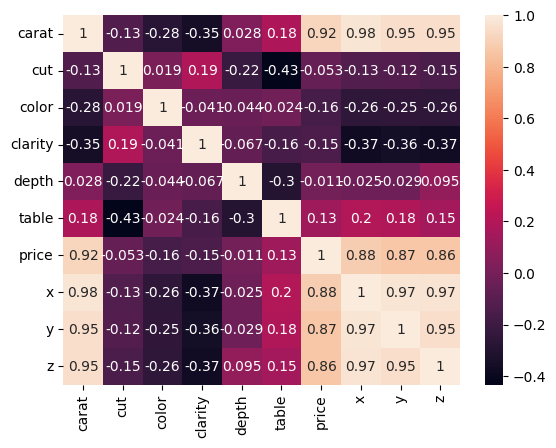

In [11]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [12]:
# x, y, z alanları neredeyse birbirlerinin aynı. Bu alanları birleştirelim
df["size"]=df["x"]*df["y"]*df["z"]

In [13]:
df.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,size
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,3.904097,4.660271,4.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,129.849403
std,0.474011,1.116600,1.472059,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,78.245262
min,0.200000,1.000000,1.000000,1.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,3.000000,4.000000,3.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,65.136830
50%,0.700000,4.000000,4.000000,4.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,114.808572
75%,1.040000,5.000000,6.000000,5.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,170.842451
max,5.010000,5.000000,7.000000,8.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,3840.598060


In [14]:
#boyutu 0 olanlar var. Onları çıkaralım
df=df[df["size"]>0]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53920 entries, 1 to 53940
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53920 non-null  float64
 1   cut      53920 non-null  int64  
 2   color    53920 non-null  int64  
 3   clarity  53920 non-null  int64  
 4   depth    53920 non-null  float64
 5   table    53920 non-null  float64
 6   price    53920 non-null  int64  
 7   x        53920 non-null  float64
 8   y        53920 non-null  float64
 9   z        53920 non-null  float64
 10  size     53920 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 4.9 MB


<Axes: ylabel='size'>

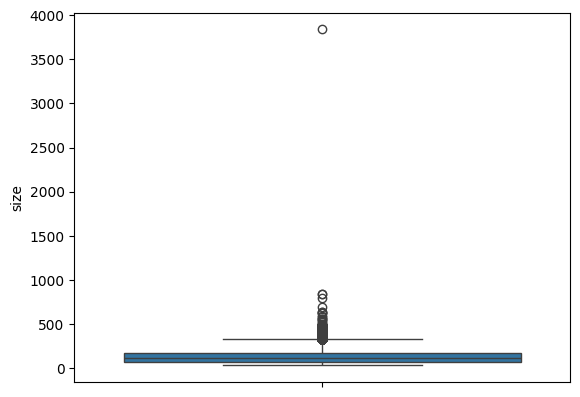

In [16]:
sns.boxplot(y=df["size"])

In [17]:
# Uç noktalar var. En uç olanı çıkaralım
df=df[df["size"]<1000]

## Modelleme

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
       
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        #Hata ve doğruluk oranlarını bir tablo haline getirmek için bir dataframe oluşturuyorum
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
                
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
                 
        #result adlı tabloya doğruluk ve hata oranlarımı yerleştiriyorum
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
       #oluşturduğum result tablosunu doğruluk oranına (r2_score) göre sıralayıp dönüyor
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [19]:
x=df.drop(["price", "x", "y", "z"], axis=1)
y=df[["price"]]

In [20]:
x.shape, y.shape

((53919, 7), (53919, 1))

In [21]:
algo_test(x,y)

,R_Squared,RMSE,MAE
XGBRegressor,0.979152,577.686226,300.627168
Gradient Boosting,0.974546,638.332362,356.553538
Extra Tree,0.965561,742.489411,370.553474
Decision Tree,0.963740,761.863818,376.347088
KNeighborsRegressor,0.958559,814.475407,419.329432
Lasso,0.908295,1211.608059,850.688391
Ridge,0.908199,1212.236984,851.511098
Linear,0.908179,1212.370251,851.648601
ElasticNet,0.906304,1224.689016,831.320291


### Feature Importance

In [22]:
lr=LinearRegression()

In [23]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)

In [24]:
model=lr.fit(x_train, y_train)

In [25]:
tahmin = model.predict(x_test)

In [26]:
r2_score(y_test, tahmin)

0.9081792289459796

In [27]:
mean_squared_error(y_test, tahmin) ** .5

1212.3702506814677

In [28]:
feature_importance=pd.DataFrame({"Feature":x_train.columns, "Coefs": lr.coef_[0]})
feature_importance=feature_importance.sort_values(by="Coefs", ascending=False)
feature_importance

,Feature,Coefs
0,carat,6996.752153
3,clarity,524.556361
2,color,360.110636
1,cut,118.165301
6,size,10.922189
5,table,-19.109938
4,depth,-34.987790


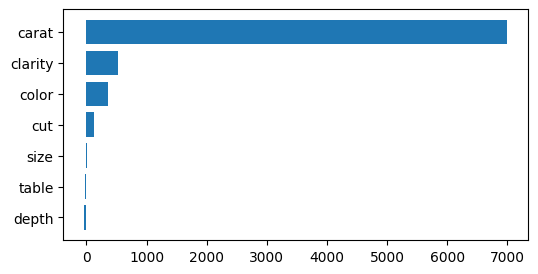

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.barh(feature_importance["Feature"], feature_importance["Coefs"]);
plt.gca().invert_yaxis()

In [30]:
residuals=y_test-tahmin
residuals

,price
34706,-976.194095
21100,595.580795
23686,1980.868893
39202,-1239.719315
35562,473.792305
...,...
6433,-1690.941105
14695,-448.878460
20509,-2946.367616
49623,1467.454379


<Axes: ylabel='Count'>

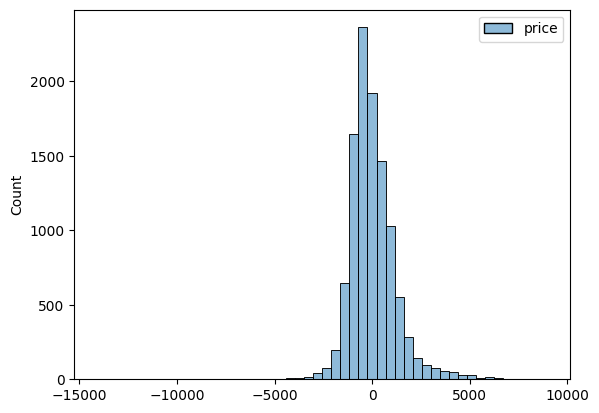

In [31]:
sns.histplot(residuals, bins=50)

<Axes: xlabel='price', ylabel='Density'>

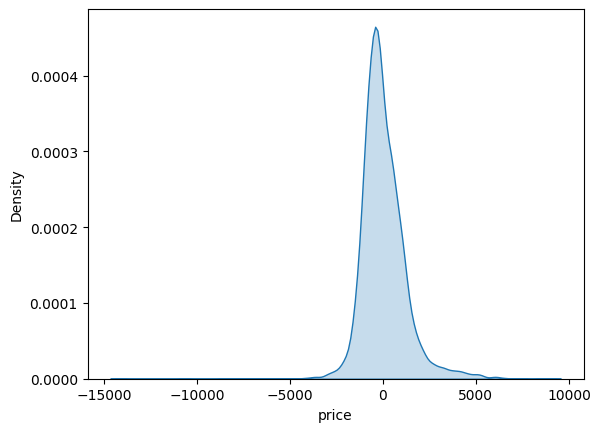

In [32]:
sns.kdeplot(x=residuals["price"], fill=True)

# Sonuç
Bu projede bir elmasın fiyatı tahmin edilmeye çalışıldı. Geliştirilen Regression modelinde en yüksek başarı oranı XGBRegressor modeli ile yaklaşık %98 olarak hesaplanmıştır.
<br> Bu modeli yeniden eğiterek kaydedip Streamlit uygulaması için kullanalım.

In [33]:
xgb=XGBRegressor()

In [34]:
model=xgb.fit(x,y)

In [35]:
import pickle
pickle.dump(model, open('diamond_model.pkl', 'wb'))

In [36]:
x.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'size'], dtype='object')

In [37]:
o=[[0.31,4,5,8,61.6,58.0,50.711228]]
model.predict(o)

array([994.4142], dtype=float32)

Hazırlanan uygulama <a href="https://huggingface.co/spaces/abdullatifkaban/Diamond_Price_Prediction" target=_blank>
<u>Hugging Face</u></a> üzerinden yayımlanmıştır.